# Closed system simulations

In [963]:
using Plots, LaTeXStrings, LinearAlgebra, Arpack, QuantumOptics
pyplot();

First, we set up the spin-1/2 sites and Pauli operators.

In [964]:
b = SpinBasis(1//2)
I = identityoperator(b)
sx, sy, sz, sp, sm = sigmax(b), sigmay(b), sigmaz(b), sigmap(b), sigmam(b)
up, down = spinup(b), spindown(b)
ψx = eigenstates(dense(sx))[2][1]
tpow(x, n) = ⊗(repeat([x], n)...);

To create a $N$-site spin loop, we need to construct the basis for the loop and operators for each site.

In [965]:
N = 8
B = tpow(b, N)
site(i, op) = embed(B, (i-1)%N + 1, op); # Periodic boundary

We now construct the transverse-field Ising Hamiltonian
$$
\ham
= -\sum_{i=1}^N J_i \pauli_{zi} \pauli_{z(i+1)} - \sum_i h_i \pauli_{xi}
$$
We nondimensionalize time with $\tau = \omega t$, where $\omega = \mu_0 h / \hbar$.

In [966]:
Jh = 0.2
J = Jh*ones(N)
h = ones(N)
H = -sum(J[i]*site(i, sz)*site(i + 1, sz) + h[i]*site(i, sx) for i in 1:length(h));

The \term{magnetization} is
$$
\opr{M}
= \frac{1}{N} \sum_{i=1}^N \pauli_{zi}.
$$

In [967]:
M = (1/N) * sum(site(i, sz) for i in 1:N);

Now we time-evolve the system and look at the expectation values of some operators. Since higher moments are present, the ribbons are only meant as rough guides to the variances.

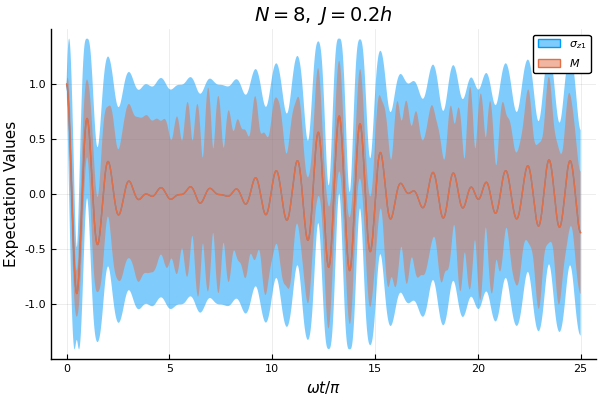

In [968]:
p = plot(xlabel="Time", ylabel="Expectation Values")
fout(t, ρ) = real([
        expect(sz, ptrace(ρ, [2:N;]))
        variance(sz, ptrace(ρ, [2:N;]))
#         expect(sx, ptrace(ρ, [2:N;]))
        expect(M, ρ)
        variance(M, ρ)
        ])
for _ in 1:1
#     ψ0 = tpow(ψx, N)
    ψ0 = tpow(up, N)
#     ψ0 = tpow(randstate(b), N)
#     ψ0 = randstate(B)
    
#     rop = randoperator(B)
#     ρ0 = normalize(rop + dagger(rop))
#     ρ0 = dm(ψ0)
#     ρ0 = thermalstate(H, 100)
        
    # Interval to save results is more coarse than the solver step size.
    ts, fouts = timeevolution.schroedinger(π*[0:0.01:25;], ψ0, H, fout = fout)
#     ts, fouts = timeevolution.master(π*[0:0.01:5;], ρ0, H, [], fout = fout)
    vals = hcat(fouts...)'
    plot!(ts / π, vals[:,1:2:end], ribbon = sqrt.(vals[:,2:2:end]),
        title = latexstring("N = $N,\\; J = $Jh h"),
        label = [L"\sigma_{z1}" L"M"],
        xlabel = L"\omega t / \pi", ylabel = "Expectation Values")
end
p